In [1]:
import glob, os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
from __future__ import print_function

import tensorflow as tf

from keras.layers import Flatten, Dense, Reshape
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras import losses
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import models
from keras import layers
import keras

from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D



import numpy as np
import pandas as pd
import sys
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
#from keract import get_activations
import numpy as np 
import pandas as pd 
from tensorflow import keras
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras import losses
import numpy as np
import os, glob

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
def pairwise_dist(A):
    # Taken frmo https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)
    r = tf.reshape(r, [-1, 1])
    D = tf.maximum(r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r), 1e-7)
    D = tf.sqrt(D)
    return D

def dist_corr(X, Y):
    n = tf.cast(tf.shape(X)[0], tf.float32)
    a = pairwise_dist(X)
    b = pairwise_dist(Y)
    A = a - tf.reduce_mean(a, axis=1) - tf.expand_dims(tf.reduce_mean(a, axis=0), axis=1) + tf.reduce_mean(a)
    B = b - tf.reduce_mean(b, axis=1) - tf.expand_dims(tf.reduce_mean(b, axis=0), axis=1) + tf.reduce_mean(b)
    dCovXY = tf.sqrt(tf.reduce_sum(A*B) / (n ** 2))
    dVarXX = tf.sqrt(tf.reduce_sum(A*A) / (n ** 2))
    dVarYY = tf.sqrt(tf.reduce_sum(B*B) / (n ** 2))
    
    dCorXY = dCovXY / tf.sqrt(dVarXX * dVarYY)
    return dCorXY

def custom_loss1(y_true,y_pred):
    dcor = dist_corr(y_true,y_pred)
    return dcor

def custom_loss2(y_true,y_pred):
    recon_loss = losses.categorical_crossentropy(y_true, y_pred)
    return recon_loss

In [4]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [5]:
DATA_DIR = "../UTKFace/"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

In [6]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df = df[(df['age'] > 10) & (df['age'] < 65)]

df.head()

../UTKFace/61_1_20170109142408075.jpg.chip.jpg
../UTKFace/39_1_20170116174525125.jpg.chip.jpg
../UTKFace/61_1_20170109150557335.jpg.chip.jpg


,age,gender,race,file
1,61.0,male,white,../UTKFace/61_0_0_20170117193447568.jpg.chip.jpg
4,32.0,female,black,../UTKFace/32_1_1_20170115235041750.jpg.chip.jpg
5,20.0,male,white,../UTKFace/20_0_0_20170116201311689.jpg.chip.jpg
7,53.0,male,indian,../UTKFace/53_0_3_20170119205931304.jpg.chip.jpg
8,45.0,female,black,../UTKFace/45_1_1_20170116003204136.jpg.chip.jpg


In [7]:
p = np.random.RandomState(10).permutation(len(df))
print(p)
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

[15086  9370   344 ... 17728  7293 17673]


(9079, 3891, 5559, 64.0)

In [8]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                images = np.array(images)
                flattened_images = np.reshape(images, (-1, IM_HEIGHT * IM_WIDTH * 3))
                yield images, [flattened_images, np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [26]:
alpha1, alpha2 = 0., 1.0
stage_num, block_num = 0, 2
experiment_name = "UTKFace_SGD_{}_{}_{}_{}".format(alpha1, alpha2, stage_num, block_num)

In [27]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from keras import losses
import numpy as np
import os

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

n = 3
depth = n * 9 + 2

input_shape = (IM_HEIGHT, IM_WIDTH, 3)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 3e-4
    if epoch > 180:
        lr = 1e-6
    elif epoch > 160:
        lr = 7e-6
    elif epoch > 120:
        lr = 2e-5
    elif epoch > 80:
        lr = 8e-5
    elif epoch > 10:
        lr = 1e-4
    #print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    """
    Experiment for UTKFace -
    fmap initial size -
    conv1: 198x198x3
    conv2: 99x99x3
    conv3: 49x49x16
    conv4: 24x24x64
    stage 0: 24x24x64
    stage 1: 12x12x128
    stage 2: 6x6x256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    print(num_res_blocks)
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(3,
                  kernel_size=5,
                  strides=2,
                  padding='valid',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    conv2 = Conv2D(3,
                   kernel_size=5,
                   strides=2,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))
    conv3 = Conv2D(16,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    conv4 = Conv2D(filters = 64,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    z1 = conv1(inputs)
    z2 = conv2(z1)
    z3 = conv3(z2)
    z4 = conv4(z3)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=z3,
                     num_filters=num_filters_in,
                     conv_first=True)
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

            if stage_num == stage and block_num == res_block:
                before_flatten_dims = x.get_shape().as_list()[1:]
                split_layer = Flatten(name='split_layer')
                split_layer_output = split_layer(x)
                x = Reshape(before_flatten_dims)(split_layer_output)
                print(before_flatten_dims)
        num_filters_in = num_filters_out
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=6)(x)
    x = Flatten()(x)
    x = Dense(100,
              activation='relu',
              kernel_initializer='he_normal')(x)

    # for age calculation
    age = Dense(units=128, activation='relu')(x)
    age_output = Dense(units=1, activation='sigmoid', name='age_output')(age)

    # for race prediction
    race = Dense(units=128, activation='relu')(x)
    race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(race)

    # for gender prediction
    gender = Dense(units=128, activation='relu')(x)
    gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(gender)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=[split_layer_output, age_output, race_output, gender_output])
    return model


model = resnet_v2(input_shape=input_shape, depth=depth)

3
[25, 25, 64]


In [28]:
model.compile(loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy',
                    'split_layer': custom_loss1},
              loss_weights={'split_layer':alpha1, 'age_output': alpha2, 'race_output':alpha2, 'gender_output':alpha2},
              optimizer=Adam(lr=lr_schedule(0)),
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-5)

from keras.callbacks import ModelCheckpoint
save_dir = os.path.join(os.getcwd(), '../saved_models')
model_name = '%s_model.{epoch:03d}.h5' % experiment_name
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=batch_size)

callbacks = [
    ModelCheckpoint(filepath, monitor='val_loss'),
    lr_reducer, lr_scheduler
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=63,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//batch_size,
                             verbose=2)

Epoch 1/63
 - 86s - loss: 2.5158 - split_layer_loss: 0.9543 - age_output_loss: 0.0342 - race_output_loss: 1.3245 - gender_output_loss: 0.5473 - age_output_mae: 0.1489 - race_output_accuracy: 0.4785 - gender_output_accuracy: 0.7125 - val_loss: 3.3727 - val_split_layer_loss: 0.9820 - val_age_output_loss: 0.0593 - val_race_output_loss: 1.7674 - val_gender_output_loss: 0.8868 - val_age_output_mae: 0.1803 - val_race_output_accuracy: 0.1784 - val_gender_output_accuracy: 0.5294
Epoch 2/63
 - 66s - loss: 2.1241 - split_layer_loss: 0.9539 - age_output_loss: 0.0315 - race_output_loss: 1.1344 - gender_output_loss: 0.3623 - age_output_mae: 0.1410 - race_output_accuracy: 0.5660 - gender_output_accuracy: 0.8441 - val_loss: 2.5822 - val_split_layer_loss: 0.9772 - val_age_output_loss: 0.0382 - val_race_output_loss: 1.4666 - val_gender_output_loss: 0.4457 - val_age_output_mae: 0.1457 - val_race_output_accuracy: 0.3807 - val_gender_output_accuracy: 0.7930
Epoch 3/63
 - 67s - loss: 1.8185 - split_layer_l

In [31]:
experiment_name

'UTKFace_SGD_0.0_1.0_0_2'

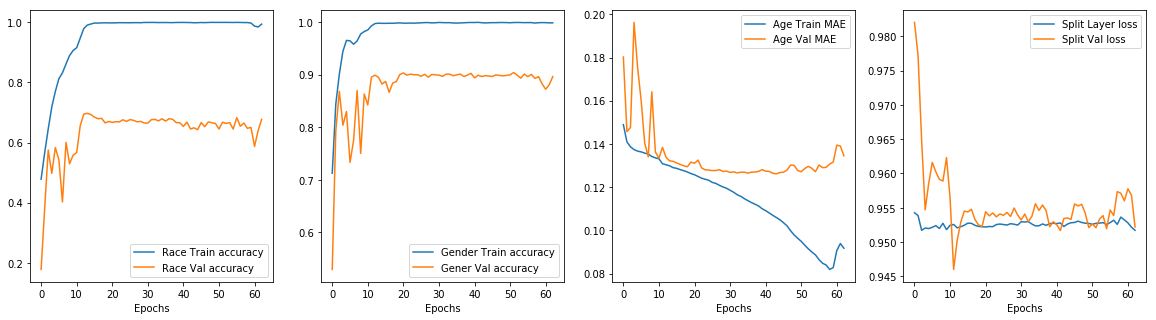

In [32]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()
    
    axes[3].plot(history.history['split_layer_loss'], label='Split Layer loss')
    axes[3].plot(history.history['val_split_layer_loss'], label='Split Val loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()
    
    """axes[4].plot(history.history['loss'], label='Training loss')
    axes[4].plot(history.history['val_loss'], label='Validation loss')
    axes[4].set_xlabel('Epochs')
    axes[4].legend()"""

plot_train_history(history)

In [18]:
len(train_idx)

9079

In [26]:
len(valid_idx)

3891

In [ ]:
#import keras
#import keras_resnet.models
#shape, classes = (32, 32, 3), 10
#x = keras.layers.Input(shape)
#model = keras_resnet.models.ResNet50(x, classes=classes)
#model.compile("adam", "categorical_crossentropy", ["accuracy"])
#(training_x, training_y), (_, _) = keras.datasets.cifar10.load_data()
#training_y = keras.utils.np_utils.to_categorical(training_y)
#model.fit(training_x, training_y)
#model.layers.pop()
#model.summary()

In [67]:
from keras.models import load_model
model = load_model('./saved_models/{}.h5'.format(experiment_name),
                   custom_objects={'custom_loss1': custom_loss1})

(None, None)


In [56]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'age_output_loss': 0.0355670265853405,
 'age_output_mae': 0.14920027554035187,
 'gender_output_accuracy': 0.7033066749572754,
 'gender_output_loss': 0.577290415763855,
 'loss': 217.05780029296875,
 'race_output_accuracy': 0.4478560984134674,
 'race_output_loss': 1.3727226257324219,
 'split_layer_loss': 0.21811041235923767}

In [62]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'loss': 3.2583343982696533,
 'split_layer_loss': -2.218268394470215,
 'age_output_loss': 0.030641425400972366,
 'race_output_loss': 2.5436744689941406,
 'gender_output_loss': 0.8520989418029785,
 'age_output_mae': 0.13043132424354553,
 'race_output_accuracy': 0.7434592843055725,
 'gender_output_accuracy': 0.9222383499145508}

In [33]:
Z_HEIGHT = Z_WIDTH = 25
Z_CHANNEL = 64
x_test_encoded = np.random.randn(0, Z_HEIGHT, Z_WIDTH, Z_CHANNEL)
x_raw = np.random.randn(0, IM_HEIGHT, IM_WIDTH, 3)
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)

for test_data_batch in test_gen:
    test_prediction = model.predict(test_data_batch[0])
    x_raw = np.concatenate((x_raw, test_data_batch[0]))
    x_test_encoded = np.concatenate((x_test_encoded, test_prediction[0].reshape(-1, Z_HEIGHT, Z_WIDTH, Z_CHANNEL)))

In [34]:
import os
out_dir = '/tf/datasets/{}/output/'.format(experiment_name)
inp_dir = '/tf/datasets/{}/input/'.format(experiment_name)
os.makedirs(out_dir)
os.makedirs(inp_dir)
for i in range(x_raw.shape[0]):
    #np.save('rawCifar10_baseline/'+str(i), x_test[i],allow_pickle = True)
    #np.save('noSmashCifar10_baseline/'+str(i), x_test_encoded[0][i].reshape(32, 32, 3),allow_pickle = True)
    np.save('{}/{}'.format(out_dir, i), x_test_encoded[i].reshape(Z_HEIGHT, Z_WIDTH, Z_CHANNEL), allow_pickle = True)
    np.save('{}/{}'.format(inp_dir, i), x_raw[i].reshape(IM_HEIGHT, IM_WIDTH, 3), allow_pickle = True)

    #matplotlib.image.imsave('rawCifar10/'+str(i)+'.png', x_test[i])
    #matplotlib.image.imsave('smashCifar10/'+str(i)+'.png', x_test_encoded[0][i].reshape(32, 32, 3))

In [16]:
experiment_name

'UTKFace_SGD_1000.0_1.0_1_1'

In [16]:
import pickle
with open('/tf/datasets/{}/trainHistoryDict'.format(experiment_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

W1113 07:35:16.825159 140231503546176 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1113 07:35:16.863367 140231503546176 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1113 07:35:16.902718 140231503546176 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1113 07:35:16.950160 140231503546176 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1113 07:35:17.000658 140231503546176 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1113 07:35:17.039287 140231503546176 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1113 07:35:17.079440 140231

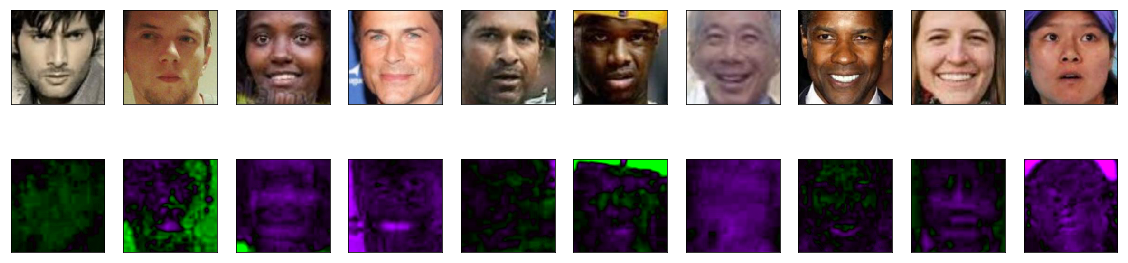

In [14]:
#test raw vs smash
n = 20
plt.figure(figsize=(40, 5))
for i in range(10,20):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_raw[i])
    #plt.imshow((x_test[i] * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_encoded[i].reshape(97, 97, 3))
    #plt.imshow((x_test_encoded[0][i].reshape(32, 32, 3) * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [15]:
import os
experiment_name = "{}-{}-UTKFace-last".format(alpha1, alpha2)
out_dir = './datasets/{}/output/'.format(experiment_name)
inp_dir = './datasets/{}/input/'.format(experiment_name)
os.makedirs(out_dir)
os.makedirs(inp_dir)
for i in range(x_raw.shape[0]):
    #np.save('rawCifar10_baseline/'+str(i), x_test[i],allow_pickle = True)
    #np.save('noSmashCifar10_baseline/'+str(i), x_test_encoded[0][i].reshape(32, 32, 3),allow_pickle = True)
    np.save('{}/{}'.format(out_dir, i), x_test_encoded[i].reshape(Z_HEIGHT, Z_WIDTH, 3), allow_pickle = True)
    np.save('{}/{}'.format(inp_dir, i), x_raw[i].reshape(IM_HEIGHT, IM_WIDTH, 3), allow_pickle = True)

    #matplotlib.image.imsave('rawCifar10/'+str(i)+'.png', x_test[i])
    #matplotlib.image.imsave('smashCifar10/'+str(i)+'.png', x_test_encoded[0][i].reshape(32, 32, 3))

In [16]:
import pickle

with open('./saved_models/{}'.format(experiment_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
#train raw vs smash
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_encoded[0][i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
#Uncomment and use below to get activations. Also try to get for particual layer at a time via book, instead of enumerating all.
#from keract import get_activations
#activations = get_activations(model, x_test[1:2])
#from keract import display_activations
#display_activations(activations, cmap="gray", save=False)

In [ ]:
x_test_encoded[0][1].shape

In [ ]:
x_testRaw.shape